In [62]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage.segmentation import slic, watershed
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

In [22]:
pizza1 = cv.imread("pizza1.jpg")
pizza2 = cv.imread("pizza2.jpg")
road1 = cv.imread("road1.jpg")
road2 = cv.imread("road2.jpg")
road3 = cv.imread("road3.jpg")
road4 = cv.imread("road4.jpg")
chair2 = cv.imread("chair2.jpg")
chair3 = cv.imread("chair3.jpg")

In [23]:
images = {}
images['pizza1'] = pizza1
images['pizza2'] = pizza2 
images['road1'] = road1 
images['road2'] = road2 
images['road3'] = road3 
images['road4'] = road4 
images['chair2'] = chair2 
images['chair3'] = chair3 

In [50]:
def display_images_grid(n_rows, n_cols, images_dict, figsize):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    if n_rows == 1 or n_cols == 1:
        for i, (title, image) in enumerate(images_dict.items()):
            image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            axes[i].imshow(image_rgb)
            axes[i].set_title(title)
            axes[i].axis('off')
    else:
        for (title, image), ax in zip(images_dict.items(), axes.ravel()):
            image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
            ax.set_title(title)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


In [25]:
def kmeans(image, criteria, k, best_labels, attempts):
    image_reshaped = image.reshape((-1, 3))
    image_reshaped = np.float32(image_reshaped)
    ret, label, center = cv.kmeans(image_reshaped, K=k, bestLabels=best_labels, criteria=criteria, attempts=attempts, flags=cv.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    return center, res2

In [26]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k_clusters = 5
attempts = 10
best_labels = None

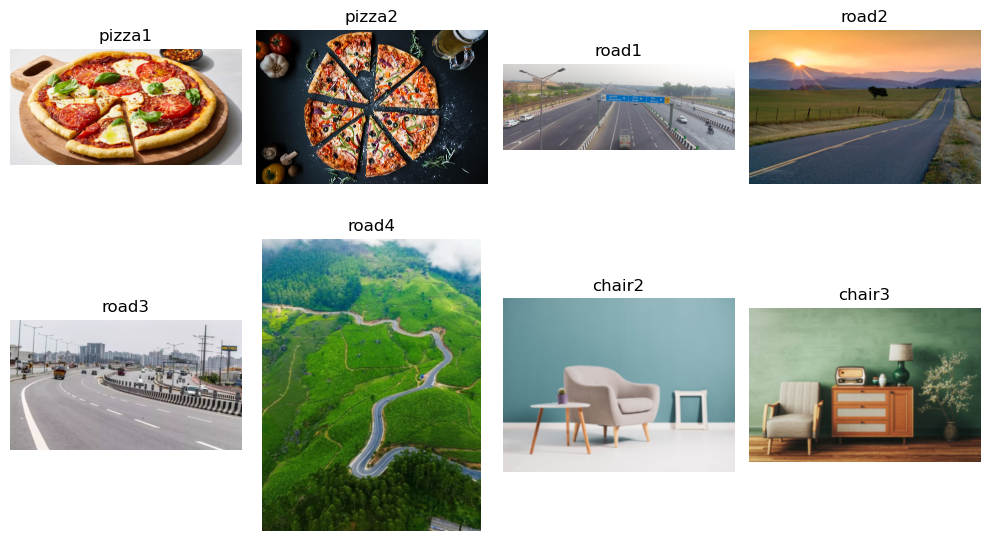

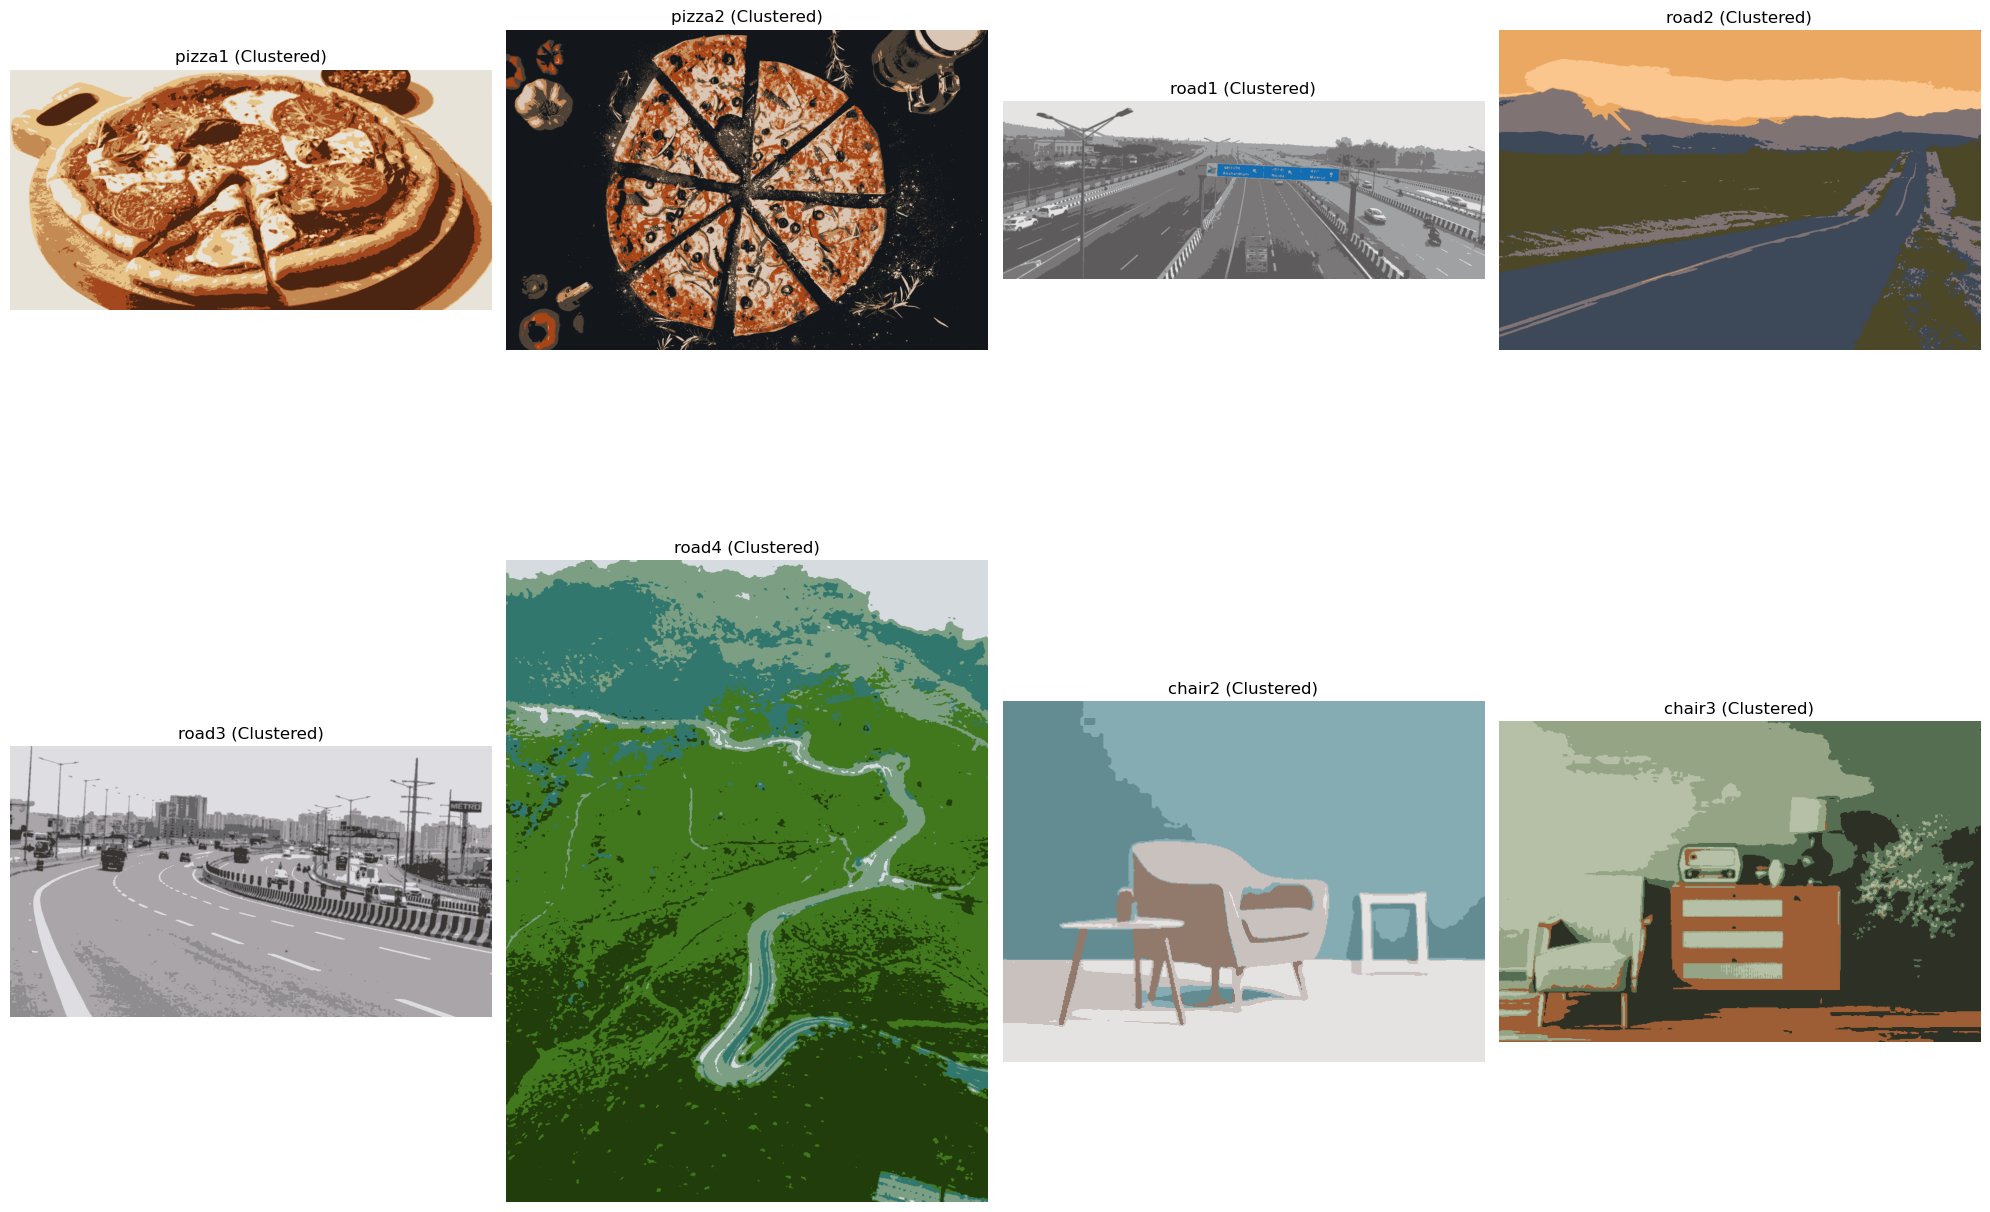

In [27]:
# Apply Gaussian blur to all images
for title, image in images.items():
    images[title] = cv.GaussianBlur(image, (5, 5), 0)

display_images_grid(2, 4, images, (10, 6))

clustered_images = {}
for title, image in images.items():
    _, clustered_image = kmeans(image, criteria, k_clusters, best_labels, attempts)
    clustered_images[title + ' (Clustered)'] = clustered_image

display_images_grid(2, 4, clustered_images, (20, 16))

In [29]:
def apply_superpixels(image, num_segments):
    sg = slic(image, n_segments=num_segments, compactness=10, sigma=1, start_label=1)
    final_segments = (mark_boundaries(image, sg*10)*255).astype(np.uint8)
    return final_segments

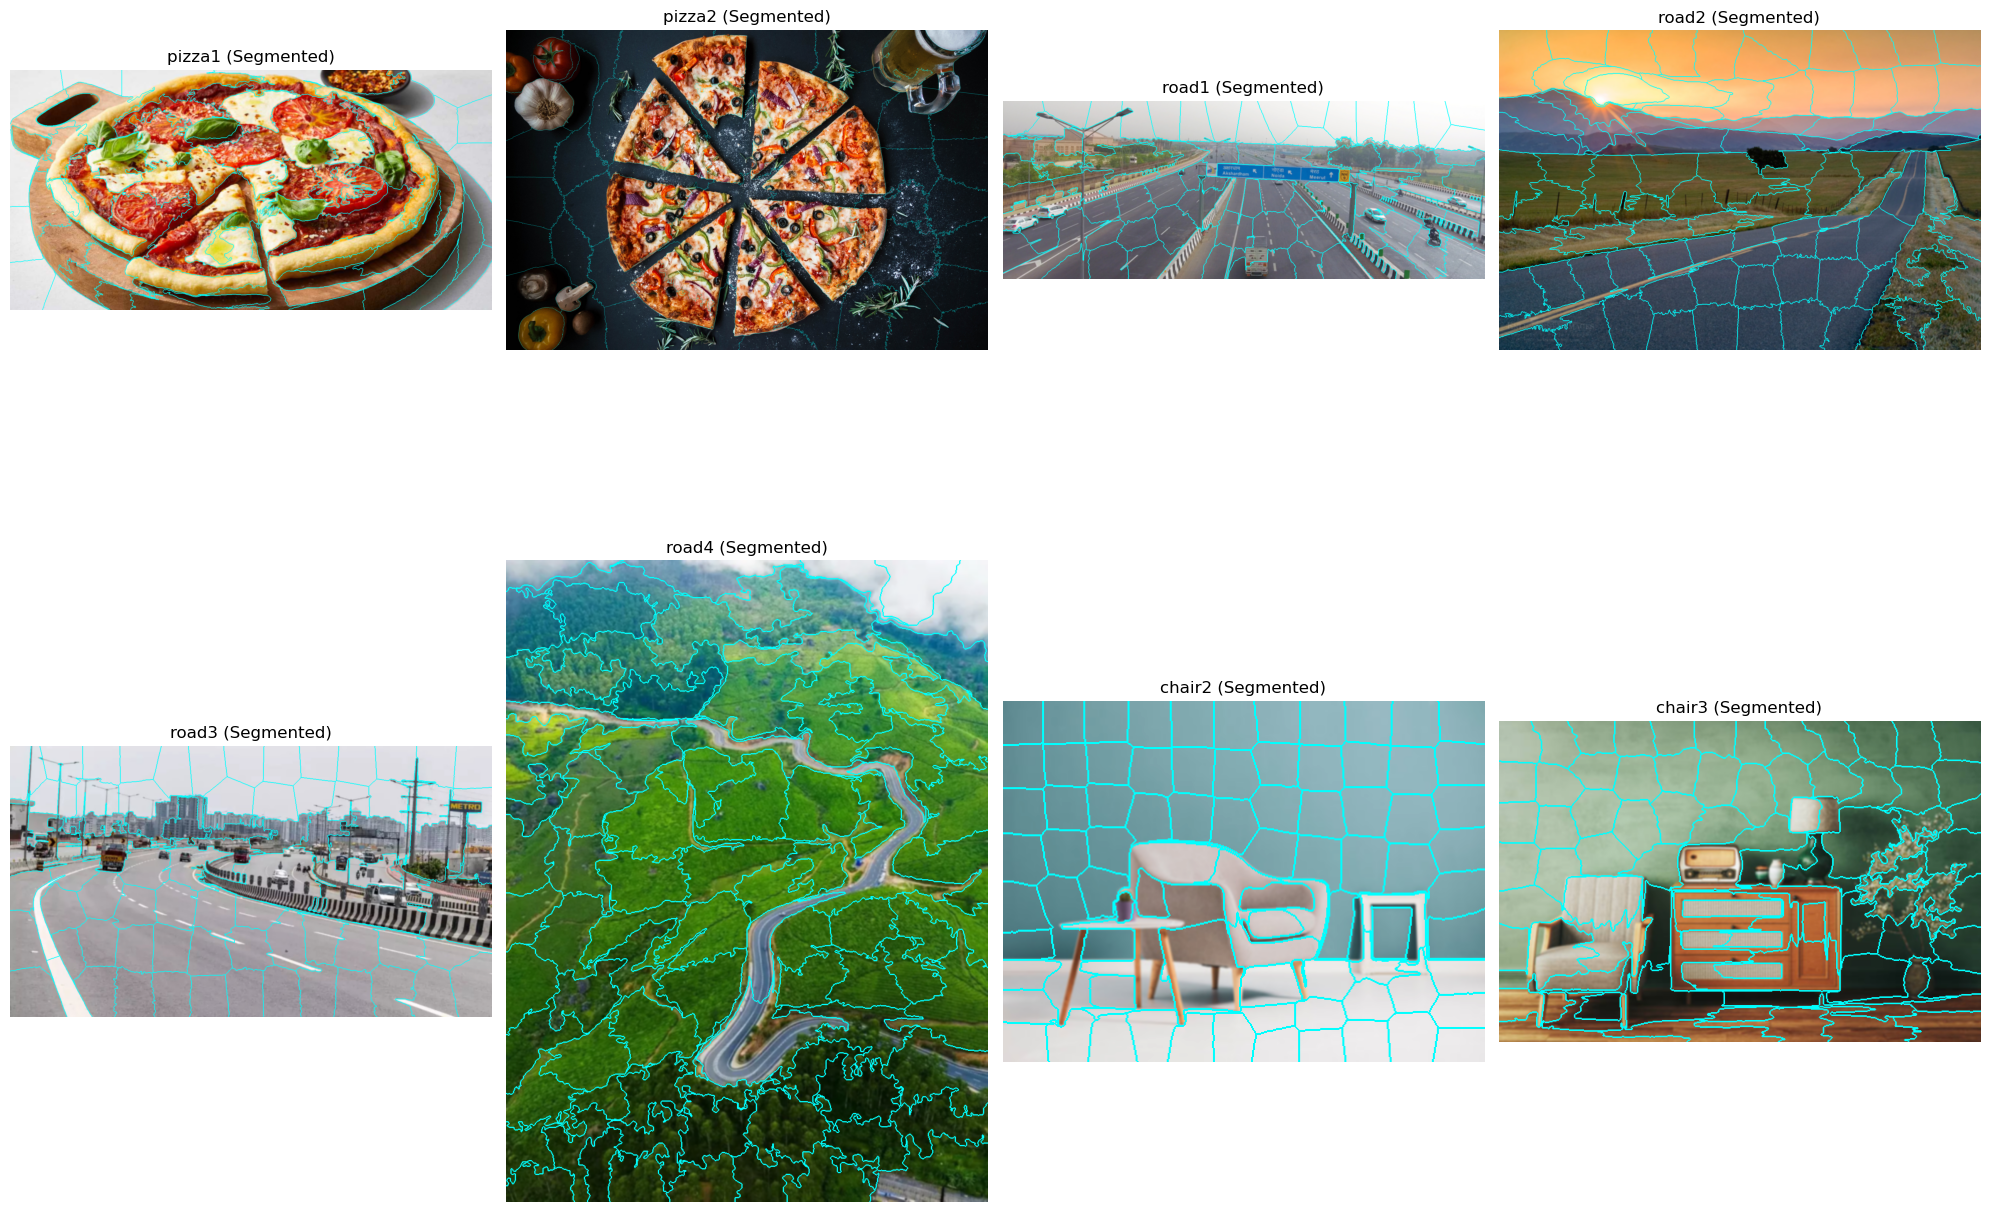

In [31]:
# Apply superpixel segmentation to all images
segmented_images = {}
num_segments = 100
for title, image in images.items():
    segmented_image = apply_superpixels(image, num_segments)
    segmented_images[title + ' (Segmented)'] = segmented_image

display_images_grid(2, 4, segmented_images, (20, 16))

In [54]:
def get_coordinates(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        global clicked_pts_list 
        global bboxes_list
        clicked_pts_list.append((x, y))
        if len(clicked_pts_list) == 2:
            width = abs(x - clicked_pts_list[0][0])
            height = abs(y - clicked_pts_list[0][1])
            bboxes_list.append((clicked_pts_list[0][0], clicked_pts_list[0][1], width, height))
            cv.destroyAllWindows()

def grab_cut(img, bbox):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)  
    mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]] = cv.GC_PR_FGD

    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)

    num_iter = 5

    for _ in range(num_iter):
        cv.grabCut(img, mask, bbox, bgModel, fgModel, 5, cv.GC_INIT_WITH_RECT)

    mask = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 1, 0).astype('uint8')
    segmented_image = img * mask[:, :, np.newaxis]
    return segmented_image


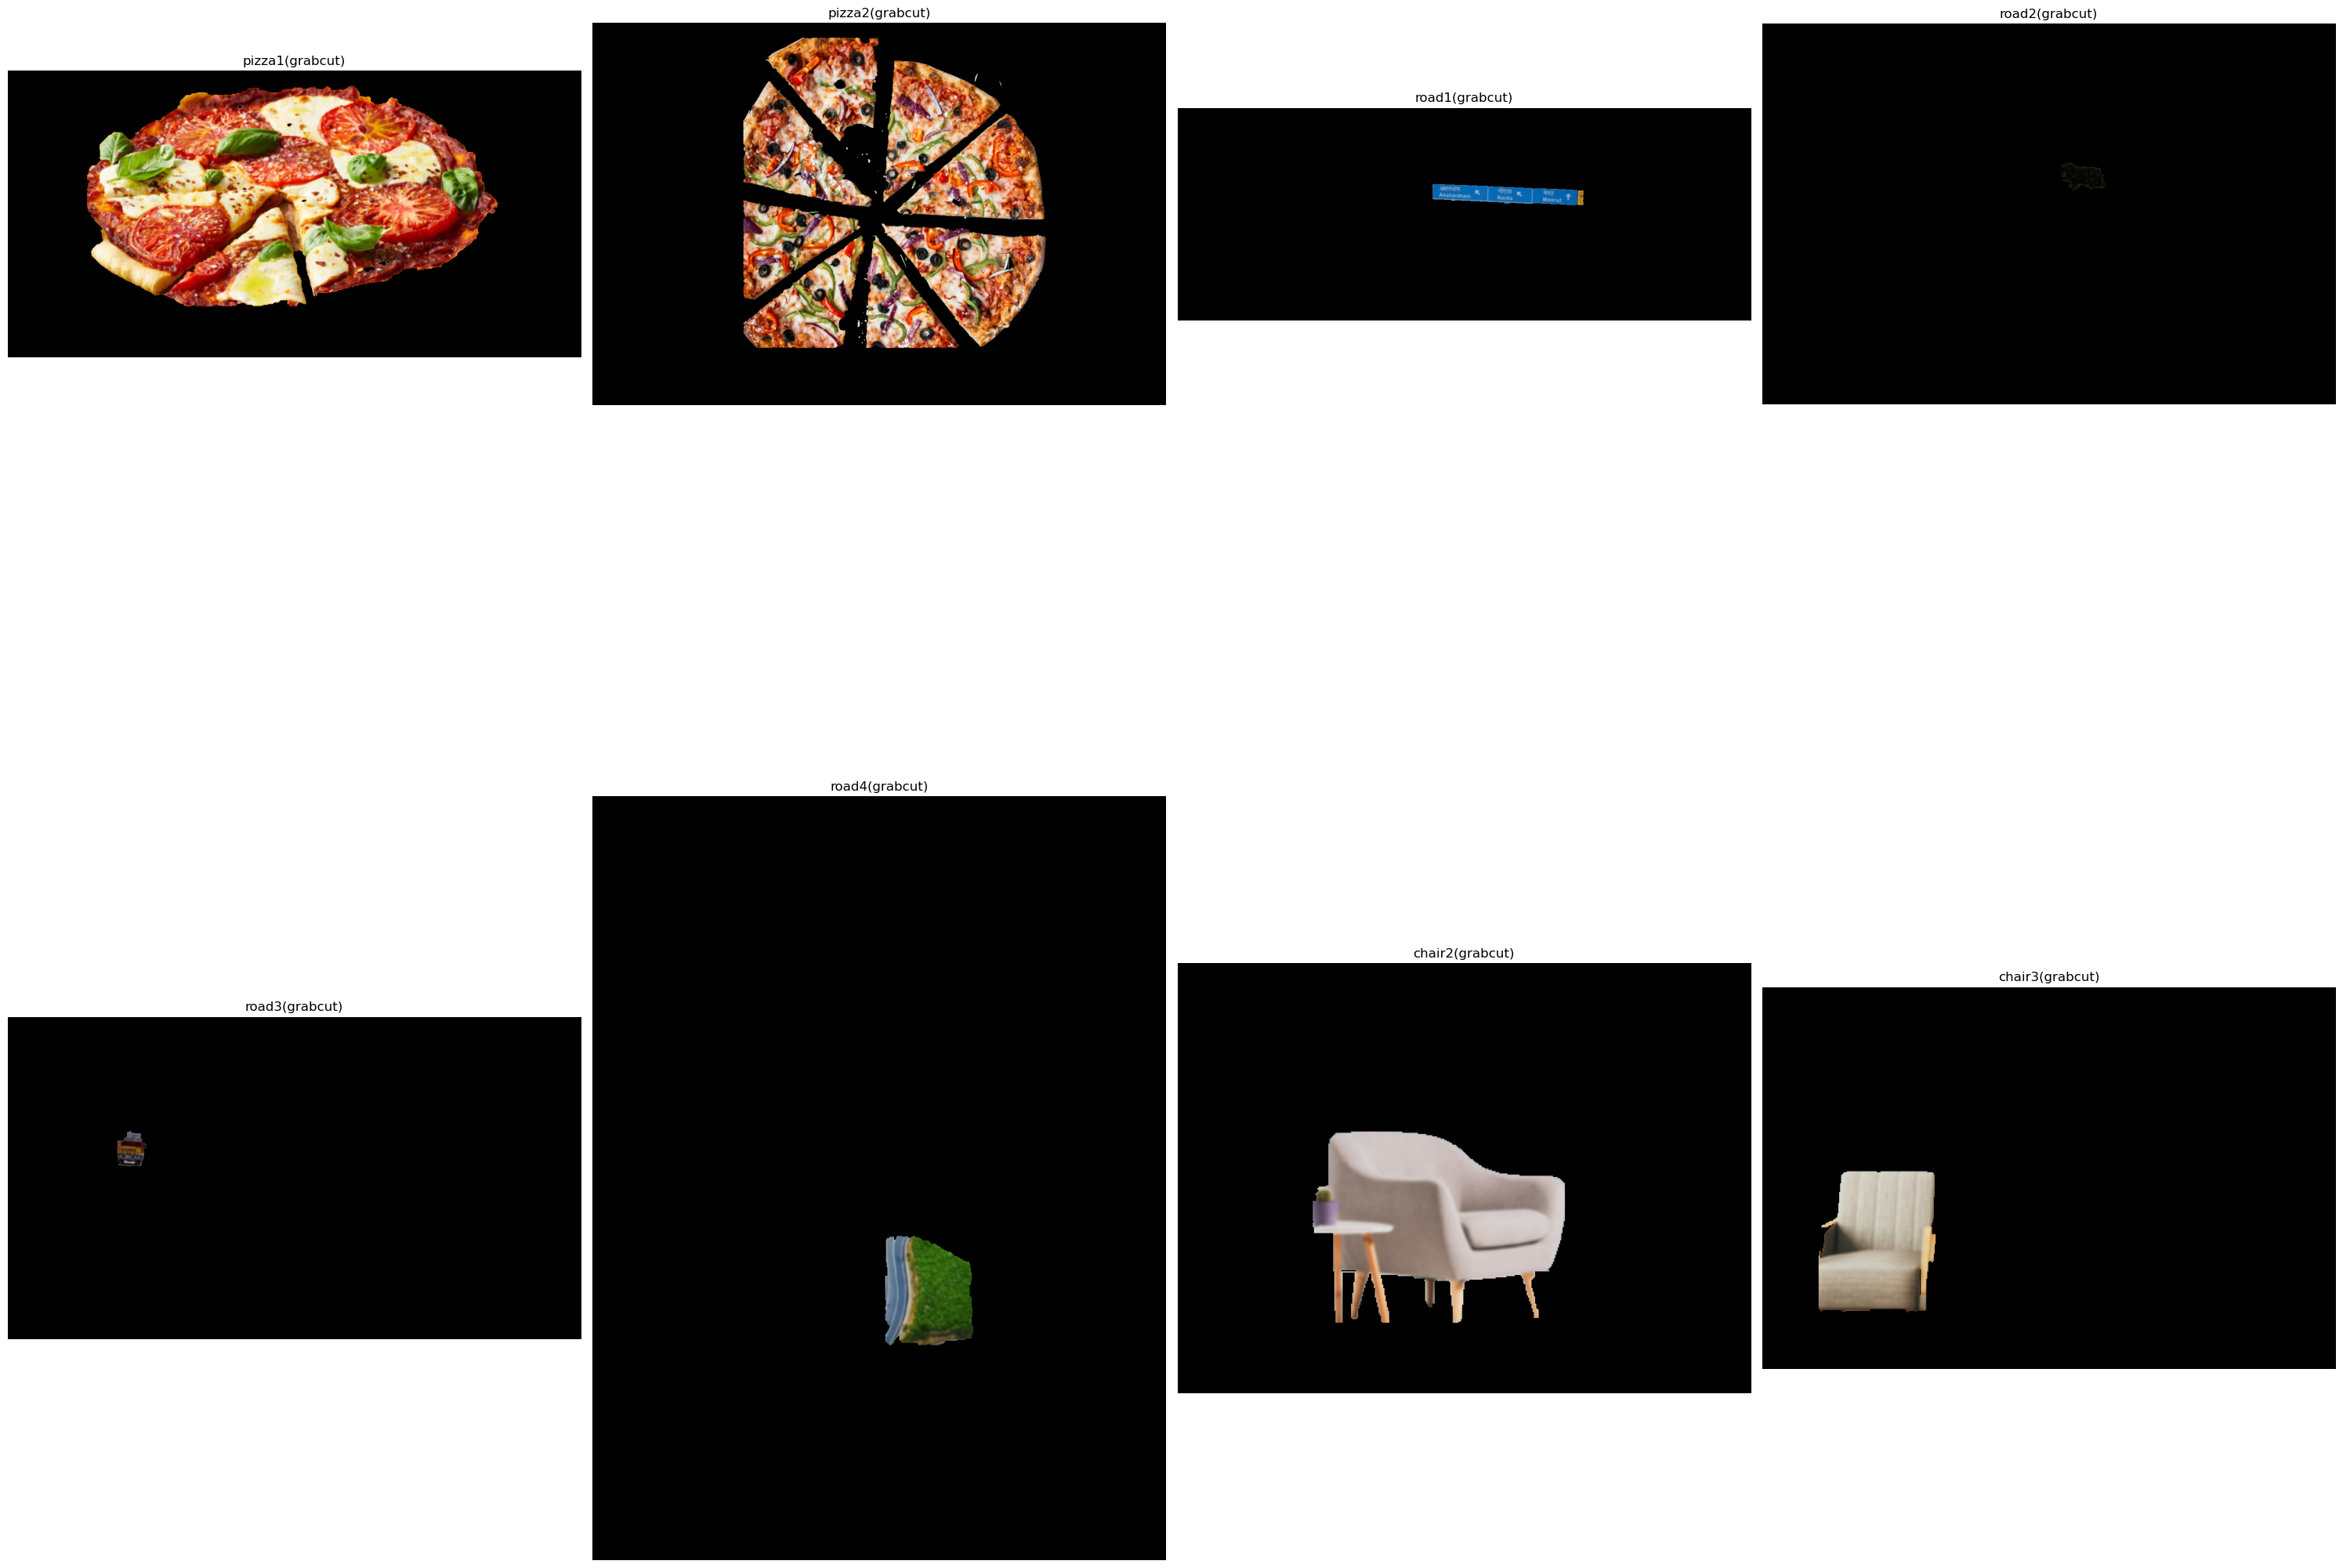

In [59]:


grabcut_images = {}
i1 = images['pizza2']
l = {}
l['pizza2'] = i1


bboxes_list = []
for img_name, img in images.items():
    clicked_pts_list = []
    cv.namedWindow("Image", cv.WINDOW_NORMAL)
    cv.imshow("Image", img)
    cv.setMouseCallback("Image", get_coordinates)
    cv.waitKey(0)
    cv.destroyAllWindows()

for idx, img_name in enumerate(images.keys()): 
    img = images[img_name]
    grabcut_images[img_name + '(grabcut)'] = grab_cut(img, bboxes_list[idx])

display_images_grid(2, 4, grabcut_images, (30, 30))


In [64]:
def apply_watersheds(image, segments):
    gradient = sobel(rgb2gray(image))
    segmented_image = watershed(gradient, markers=segments, compactness=0.0001)
    sg = (mark_boundaries(img, segmented_image*10)*255).astype(np.uint8)
    return sg

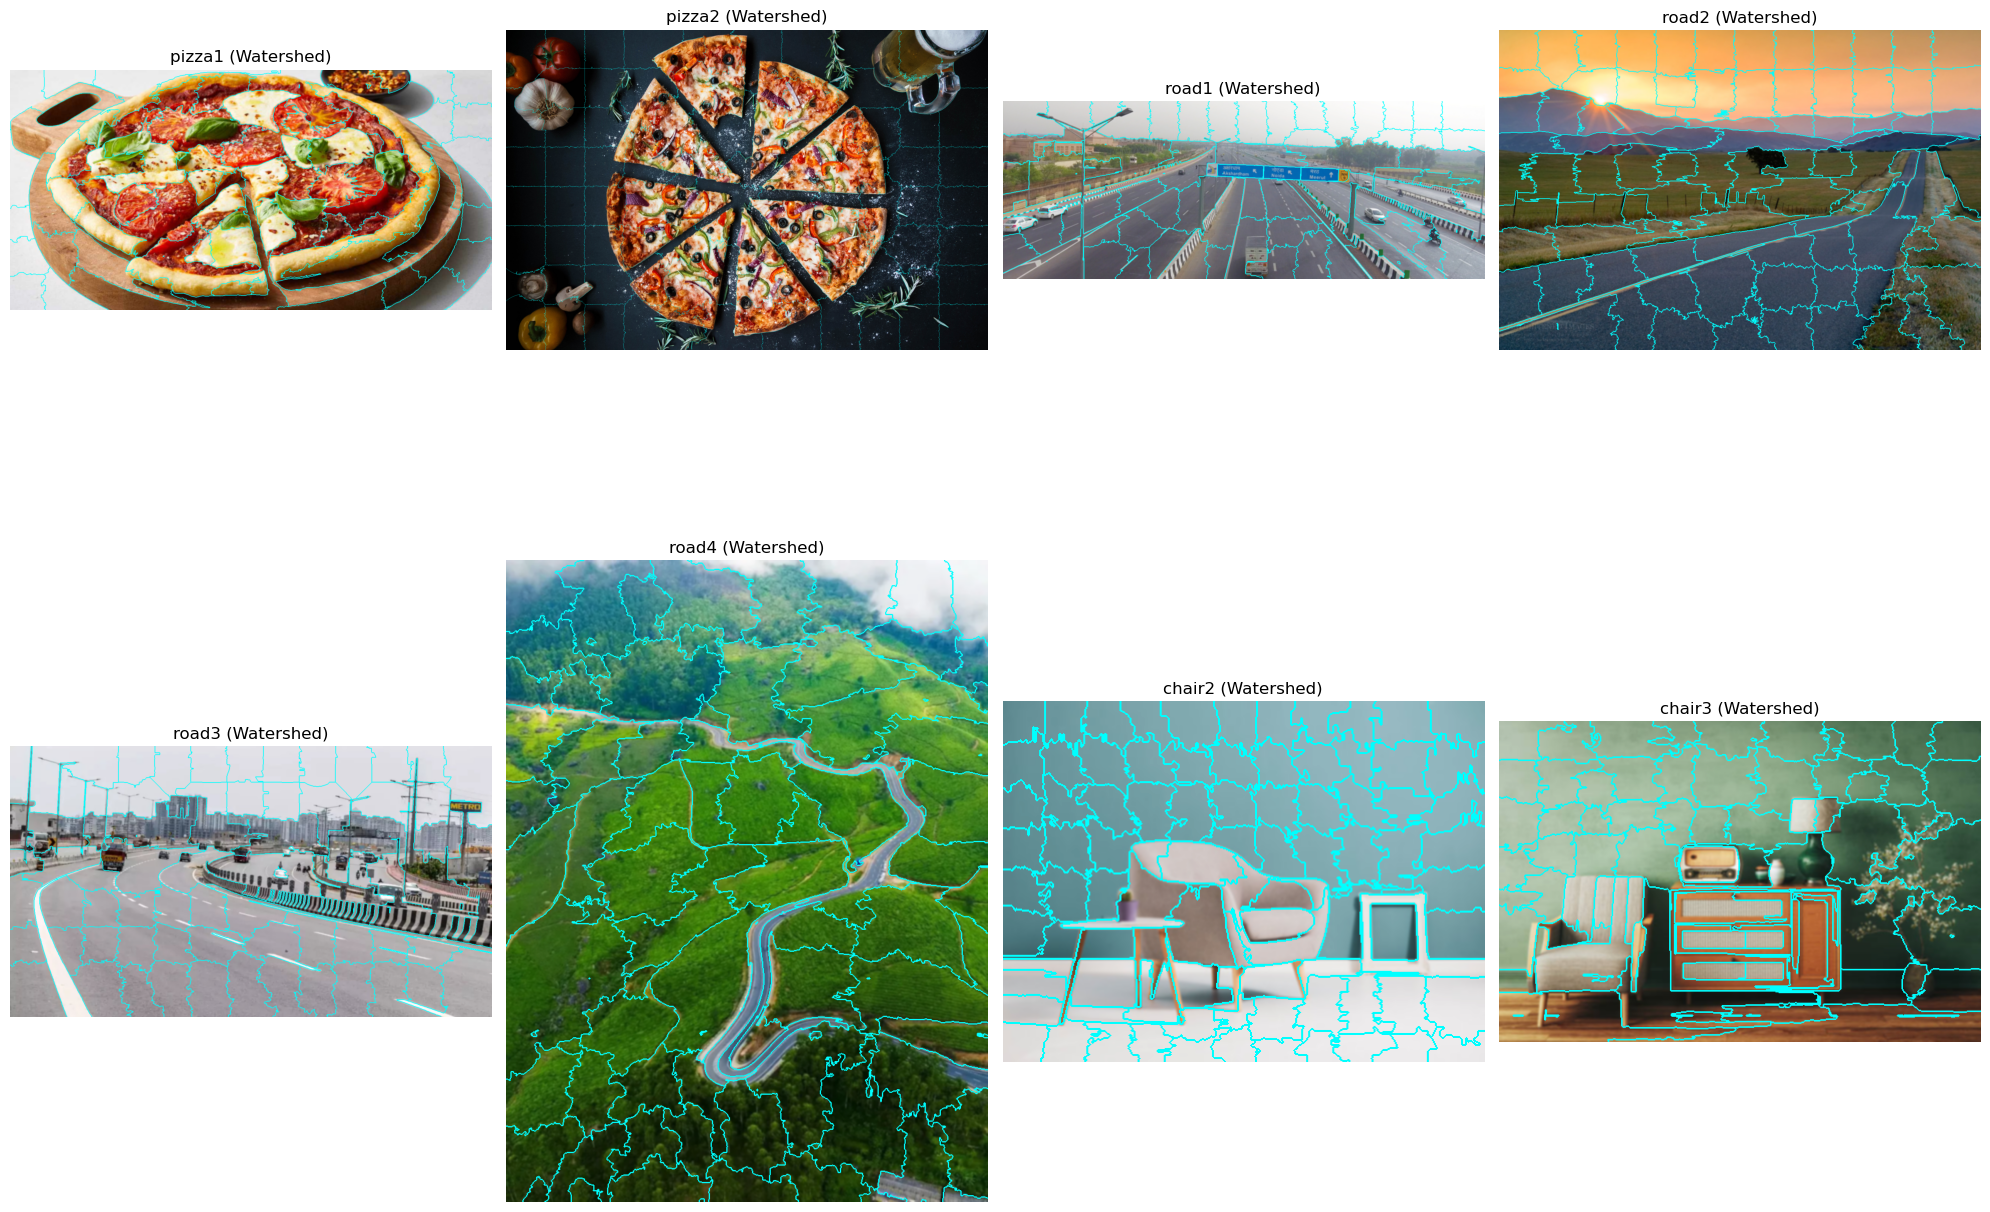

In [65]:
watershed_images = {}
for img_name, img in images.items():
    segmented_image = apply_watersheds(img, 100)
    watershed_images[img_name + ' (Watershed)'] = segmented_image

display_images_grid(2, 4, watershed_images, (20, 16))


- KMeans clustering showcases effective segmentation in images of chair2, chair3, road2, and road3, while it exhibits suboptimal performance in images of road1 and road4. The loss of detail in these latter images might be attributed to their predominant gray color tones.
- Superpixel segmentation outperforms KMeans clustering in several cases, yet it struggles with effectively segmenting the pizza and road1 and road2 images.
- GrabCut demonstrates promising results in image segmentation. However, in the case of chair3, it fails to accurately delineate the complete outline of the night lamp, possibly due to its similar shade to the surrounding wall. Similarly, in pizza1, while it successfully segments a portion of the desired piece, it also includes segments from adjacent areas. Notably, in road2, successful segmentation occurs, albeit obscured by the image's dark shading.
- Watershed segmentation, akin to superpixels, presents a comparable approach but lacks the finesse to capture intricate details. For instance, in the image of chair3, the segmentation fails to accurately delineate the tree on the right side.